# Testing Black-Scholes implementation

Here, we simply look at some real data and check if our implementation of the Black-Scholes option pricing is correct.

In [1]:
from typing import Tuple, List

import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
import yfinance as yf

from quant_learn.options.black_scholes import black_scholes_value

First, we need a way to compute the risk-free interest rate. It appears to me `yfinance` does not keep track of all different Treasury bills (from 4 weeks to 1 year), notes (2 to 5 years), and bonds (10+ years). They seem to have the 13-week T-bill `^IRX`, and others that are 5+ years (`^FVX` for 5, `^TNX` for 10, and `^TYX` for 30 years). We will most likely use the 13-week T-bill, but let's keep the others just in case. We will keep a list containing the tickers on `yfinance`, and another with the relevant periods of time, in days.

In [2]:
treasury_tickers = ['^IRX', '^FVX', '^TNX', '^TYX']
treasury_terms_days = [91, 1825, 3650, 10950]

Let's also create a few helper functions to compute the desired risk-free interest rates.

In [3]:
def get_appropriate_treasury_tickers(delta_time: np.ndarray) -> np.ndarray:
    """
    Returns the tickers to be used for computing risk-free interest rates

    Args:
        delta_time: array of timedeltas (in days) to be used for getting appropriate tickers

    Returns:
        array of appropriate tickers
    """
    # Start simple
    tickers = np.full(len(delta_time), 'unknown')

    for symbol, days in zip(treasury_tickers, treasury_terms_days):
        tickers = np.where((delta_time <= days) & (tickers == 'unknown'), symbol, tickers)
    
    # Now, just add the last one
    tickers = np.where(tickers == 0, treasury_tickers[-1], tickers)

    return tickers


def get_daily_rate_from_ticker(ticker: str) -> float:
    """
    Get appropriate risk-free interest rate from a ticker symbol

    Args:
        ticker: string to be used for treasury bond/bill/note

    Returns:
        corresponding daily interest rate
    """
    apy = yf.Ticker(ticker=ticker).history(period='1d')['Close'].values.item() / 100.
    r = np.pow((1. + apy), (1./365)) - 1.
    return r


def get_risk_free_interest_rate(present_dates: np.ndarray,
                                expiration_dates: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Computes desired daily risk-free interest rates for collection of present dates and expiration dates

    Args:
        present_dates: array of np.datetime64 objects of the present dates
        expiration_dates: array of np.datetime64 objects of the expiration dates

    Returns:
        the total time left and the daily risk-free interest rate
    """

    # First, compute the time left
    taus = (expiration_dates - present_dates).astype('int')

    # Now, the harder part: the interest rates
    # First, get tickers
    treasury_tickers = get_appropriate_treasury_tickers(delta_time=taus)

    # Get relevant interest rate
    r_values = np.array([get_daily_rate_from_ticker(ticker) for ticker in treasury_tickers])

    return taus, r_values

Let's create a function that takes in a ticker symbol and outputs the real prices and expected prices of call options for that ticker. Recall that, unlike call options with no dividends, American and European put options do not have the same theoretical price, so we will not consider put options.

In [4]:
def get_call_real_and_expected_prices(ticker: str) -> Tuple[List[Tuple[np.ndarray, np.ndarray]], List[float]]:
    """
    Retrieves real call option prices for given ticker, and computes expected price based on Black-Scholes pricing model

    Args:
        ticker: string indicating symbol to track

    Returns:
        a tuple with two elements: first, a list in which each entry is a tuple of real prices and Black-Scholes prices
        for a given expiration date; second, a list of the slopes of the linear regression fit, which ideally should be
        all equal to 1.0
    """
    # Get main ticker object
    ticker_all = yf.Ticker(ticker=ticker)

    # Let's initialize an array to collect the fits of expected price vs. actual price
    fits = []

    # Also, the main list which we will return
    prices = []

    # Collect expiration dates
    expiration_dates = ticker_all.options
    for exp_date_str in expiration_dates[:]:  # [4:5]:  # 
        # Compute relevant interest rate
        exp_date = np.datetime64(exp_date_str)
        # Skip those expiring today
        if (exp_date - np.datetime64('today', 'D')) == 0:  # skip those expiring today
            continue

        # Now, let's get the calls and puts for the expiration date
        options = {'call': ticker_all.option_chain(date=exp_date_str).calls,
                   'put': ticker_all.option_chain(date=exp_date_str).puts}

        for style, data in options.items():
            # For call options with underlying stocks that pay no dividends, the theoretical price of the American
            # option is the same as for the European option. However, that is not the case for put options, so we will
            # skip those, and only look at the call options
            if style == 'put':
                continue
            
            # Clean up the data to only look at cases where there is interest in the options
            data = data[data['openInterest'] >= 100]
            
            # Get main data
            implied_vol = data['impliedVolatility'].to_numpy()
            strike = data['strike'].to_numpy()
            spot = data['lastPrice'].to_numpy()
            value = (data['bid'].to_numpy() + data['ask'].to_numpy()) / 2.
            last_trade = data['lastTradeDate'].apply(np.datetime64).to_numpy()
            last_trade = last_trade.astype('datetime64[D]')

            # Compute appropriate time to maturity in days and appropriate risk-free interest rate
            taus, r_values = get_risk_free_interest_rate(present_dates=last_trade, expiration_dates=exp_date)

            expected_values = black_scholes_value(strike_price=strike,
                                                  spot_price=spot,
                                                  time_to_maturity=taus,
                                                  interest_rate=r_values,
                                                  volatility=implied_vol)
            expected_value = expected_values[style]

            # Let's also check how good the match is
            if len(expected_value) > 1:
                fit = linregress(x=expected_value, y=value)
                fits += [fit]
            else:
                fits += [expected_value / value]
            
            prices += [(value, expected_value)]
    
    return prices, fits

Let's look at options for some reputable stocks: Microsoft and Amazon

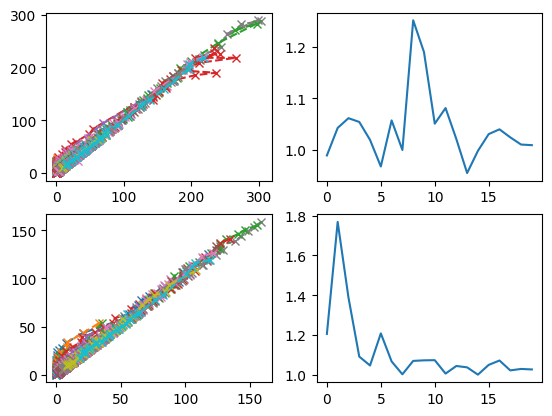

In [5]:
import warnings
# Ignore pandas warning us there is no timezone represenation for numpy datetime64
warnings.filterwarnings('ignore', category=UserWarning, module='pandas')

tickers = ["MSFT", "AMZN"]  # , 'FB']  # 

# Generate figure
fig, axes = plt.subplots(len(tickers), 2)

for i, symbol in enumerate(tickers):

    # Get prices and fits
    prices, fits = get_call_real_and_expected_prices(ticker=symbol)

    # Plot fits, which should be easier
    # Collect slopes
    slopes = np.array([result.slope for result in fits])
    # A few are NaN due to the y-values being all the same
    slopes = (slopes[~np.isnan(slopes)]).flatten()
    # Plot
    axes[i, 1].plot(slopes)

    # Plot prices
    for (value, expected_value) in prices:
            # plot main prices
            axes[i, 0].plot(expected_value, value, '--', marker='x')

These are looking pretty good! 